<a href="https://colab.research.google.com/github/kwonzero/artists_classification/blob/main/kwonzero/2_2_Vit%2B_CutMix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# augmentation
* vit model 적용
    - tiny_vit_21m_384.dist_in22k_ft_in1k
* Augmentation
    - Transpose # 행렬 스왑
    - HorizontalFlip # 좌우 반전
    - VerticalFlip # 상하 반전
    - ShiftScaleRotate # 랜덤하게 옮기고, scale, 회전
    - HueSaturationValue # 빛깔, 색조, 값 변환
    - RandomBrightnessContrast # 명도 대비
    - ChannelShuffle # RGB 채널 간 shuffle
    - CoarseDropout # 조그마한 검은 사각형 영역 추가
* lr scheduler
    - Custom CosineAnnealingWarmUpRestarts
* vit model 적용
    - tiny_vit_21m_384.dist_in22k_ft_in1k
* CutMix 적용
* result
    - train loss : 0.91428
    - validation loss : 0.50762
    - f1 score : 0.8198
    - epoch : 60

    - Public -  0.8037792451 : 25위
    - Private - 0.7884677588 : 19위

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
pip install timm

In [66]:
import gc
import os
import random
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

import warnings
warnings.filterwarnings(action='ignore')

In [67]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [68]:
CFG = {
    'IMG_SIZE': 260,
    'EPOCHS': 1000,
    'LEARNING_RATE': 1e-6,
    'BATCH_SIZE': 32,
    'PATIENCE': 10,
    'WARMUP': 5,
    'FILENAME': 'tiny_vit',
    'SEED': 6
}

In [69]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [70]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Project/CV/dataset/'
else:
    data_path = '../../data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df.loc[3896, 'artist'] = 'Titian'
df.loc[3986, 'artist'] = 'Alfred Sisley'
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [72]:
artists = df.groupby('artist')[['id']].count().rename(columns={'id':'count'}).reset_index()

In [73]:
# Label Encoding
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

In [74]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=CFG['SEED'])

In [75]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
1,1,./train/0001.jpg,48
3,3,./train/0003.jpg,10
4,4,./train/0004.jpg,24
6,6,./train/0006.jpg,43


In [76]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist
2,2,./train/0002.jpg,7
5,5,./train/0005.jpg,38
10,10,./train/0010.jpg,6
11,11,./train/0011.jpg,1
18,18,./train/0018.jpg,33


In [77]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values
    return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values, df['artist'].values

In [78]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [79]:
from torchvision.transforms import ToTensor

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms if transforms else ToTensor()

    def __getitem__(self, index):
        img_path = self.img_paths[index]

        try:
            image = cv2.imread(img_path)
            if image is None:
                raise FileNotFoundError(f"경로 {img_path}의 이미지를 불러올 수 없습니다.")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transforms(image=image)['image']

            if self.labels is not None:
                label = self.labels[index]
                return image, label
            else:
                return image

        except Exception as e:
            print(f"경로 {img_path}의 이미지를 불러오는 중 오류가 발생했습니다: {e}")
            # 오류를 graceful하게 처리: 기본 이미지와 레이블 반환
            placeholder_image = torch.zeros((3, 260, 260), dtype=torch.float32)
            if self.labels is not None:
                placeholder_label = torch.randint(50, size=(1,)).item()
                return placeholder_image, placeholder_label
            else:
                return placeholder_image

    def __len__(self):
        return len(self.img_paths)

In [80]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Transpose(p=0.5), # 행렬 스왑
    A.HorizontalFlip(p=0.5), # 좌우 반전
    A.VerticalFlip(p=0.5), # 상하 반전
    A.ShiftScaleRotate(p=0.5), # 랜덤하게 옮기고, scale, 회전
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5), # 빛깔, 색조, 값 변환
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5), # 명도 대비
    A.ChannelShuffle(), # RGB 채널 간 shuffle
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

validation_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

In [81]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

In [82]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=4)

val_dataset = CustomDataset(val_img_paths, val_labels, validation_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=4)

In [83]:
class VitModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(VitModel, self).__init__()
        self.backbone = timm.create_model('tiny_vit_21m_384.dist_in22k_ft_in1k', pretrained=True, num_classes=0)
        self.classifier = nn.Sequential(
            nn.LayerNorm(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(576, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [84]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [85]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        return self.early_stop

In [86]:
def rand_bbox(size, lam):   # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = np.int(W * cut_rat)  # 패치의 너비
    cut_h = np.int(H * cut_rat)  # 패치의 높이

    # uniform
    # 기존 이미지의 크기에서 랜덤하게 값을 가져옵니다.(중간 좌표 추출)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

# 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

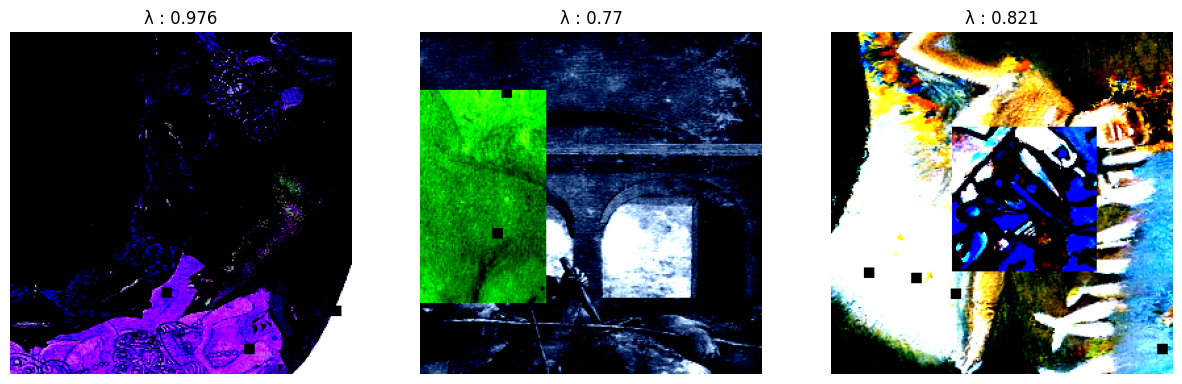

In [87]:
import matplotlib.pyplot as plt
def cutmix_plot(train_loader):
    fig , axes = plt.subplots(1,3)
    fig.set_size_inches(15,12)

    for i in range(3):
        for inputs, targets in train_loader:
            inputs = inputs
            targets = targets
            break

        lam = np.random.beta(1.0, 1.0)  # 베타 분포에서 lam 값을 가져옵나다.
        rand_index = torch.randperm(inputs.size()[0])   # batch_size 내의 인덱스가 랜덤하게 셔플됩니다.
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
        axes[i].imshow(inputs[1].permute(1, 2, 0).cpu())
        axes[i].set_title(f'λ : {np.round(lam,3)}')
        axes[i].axis('off')
    return

cutmix_plot(train_loader)

In [88]:
import math
from torch.optim.lr_scheduler import LRScheduler

class CosineAnnealingWarmUpRestarts(LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [89]:
time_now = datetime.now()
run_id = 0# time_now.strftime("%Y%m%d%H%M%S")
os.makedirs(os.path.join(data_path, f'./runs/{run_id}'), exist_ok=True)
print(f'{run_id=}')

run_id=0


In [90]:
def train(model, optimizer, criterion, train_loader, device, beta=1, cutmix_prob=0.5, r_scheduler=None):
    model.train()
    train_loss = []
    lr_list = []
    bar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Train Loop')

    for idx, (img, label) in bar:
        img, label = img.float().to(device), label.long().to(device)

        optimizer.zero_grad()
        r = np.random.rand(1)
        if beta > 0 and r < cutmix_prob:
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(img.size()[0]).cuda()
            target_a = label
            target_b = label[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]

            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))

            model_pred = model(img)
            loss = criterion(model_pred, target_a) * lam + criterion(model_pred, target_b) * (1. - lam)
            loss.backward()
            if (idx == 0) or (idx == len(train_loader)-1):
                lr_list.append(optimizer.param_groups[0]['lr'])
            optimizer.step()
        else:
            model_pred = model(img)
            loss = criterion(model_pred, label)
            loss.backward()
            if (idx == 0) or (idx == len(train_loader)-1):
                lr_list.append(optimizer.param_groups[0]['lr'])
            optimizer.step()

        train_loss.append(loss.item())
        bar.set_postfix(train_loss=f'{loss.item():.4f}')

        if r_scheduler:
            r_scheduler.step()

    return np.mean(train_loss), lr_list

In [91]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation(model, criterion, test_loader, device):
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for img, label in iter(test_loader):
            img, label = img.float().to(device), label.long().to(device)

            model_pred = model(img)

            loss = criterion(model_pred, label)

            val_loss.append(loss.item())

            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [92]:
def train_epoch(model, optimizer, train_loader, test_loader, lr_scheduler, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    early_stopping = EarlyStopping(patience=CFG['PATIENCE'], verbose=True)

    best_score = 0
    lr_list = []
    train_loss_list, val_loss_list = [], []

    for epoch in range(1, CFG["EPOCHS"] + 1):
        tr_loss, lr_ = train(model, optimizer, criterion, train_loader, device, r_scheduler=lr_scheduler)
        val_loss, val_score = validation(model, criterion, test_loader, device)
        train_loss_list.append(tr_loss)
        val_loss_list.append(val_loss)

        if lr_scheduler is not None:
            lr_list.extend(lr_)

        if best_score < val_score:
            print(f'**Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
            best_score = val_score
            torch.save(model, os.path.join(data_path, f'runs/{run_id}/best_model.pt'))
        else:
            print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        clear_mem()
        if early_stopping(val_score):
            print(f'Epoch [{epoch}], early stopping')
            break

    if lr_list:
        return train_loss_list, val_loss_list, lr_list
    else:
        return train_loss_list, val_loss_list, None


In [93]:
from torchsummary import summary

model = VitModel()
model = model.to(device)
summary(model, (3,384,384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 192, 192]           1,296
       BatchNorm2d-2         [-1, 48, 192, 192]              96
              GELU-3         [-1, 48, 192, 192]               0
            Conv2d-4           [-1, 96, 96, 96]          41,472
       BatchNorm2d-5           [-1, 96, 96, 96]             192
        PatchEmbed-6           [-1, 96, 96, 96]               0
            Conv2d-7          [-1, 384, 96, 96]          36,864
       BatchNorm2d-8          [-1, 384, 96, 96]             768
              GELU-9          [-1, 384, 96, 96]               0
           Conv2d-10          [-1, 384, 96, 96]           3,456
      BatchNorm2d-11          [-1, 384, 96, 96]             768
             GELU-12          [-1, 384, 96, 96]               0
           Conv2d-13           [-1, 96, 96, 96]          36,864
      BatchNorm2d-14           [-1, 96,

In [94]:
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG['LEARNING_RATE'])
# lr : 10epochs 동안 0.01->0
lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=CFG['WARMUP']*len(train_loader), T_mult=1, eta_max=0.001, T_up=50, gamma=0.7)

train_loss_list, val_loss_list, lr_list = train_epoch(model, optimizer, train_loader, val_loader, lr_scheduler, device)

Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [1], Train Loss : [3.29109] Val Loss : [2.42974] Val F1 Score : [0.18790]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [2], Train Loss : [2.66704] Val Loss : [2.04884] Val F1 Score : [0.32369]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [3], Train Loss : [2.30015] Val Loss : [1.54017] Val F1 Score : [0.42836]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [4], Train Loss : [1.82972] Val Loss : [1.29212] Val F1 Score : [0.51100]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [5], Train Loss : [1.76800] Val Loss : [1.24410] Val F1 Score : [0.54468]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.97667] Val Loss : [1.37455] Val F1 Score : [0.49558]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.5446805738471321


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [7], Train Loss : [1.90365] Val Loss : [1.14883] Val F1 Score : [0.62190]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [8], Train Loss : [1.71649] Val Loss : [0.98073] Val F1 Score : [0.65653]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [9], Train Loss : [1.54732] Val Loss : [0.89746] Val F1 Score : [0.68620]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [10], Train Loss : [1.43155] Val Loss : [0.90362] Val F1 Score : [0.68707]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [11], Train Loss : [1.53609] Val Loss : [1.01499] Val F1 Score : [0.65042]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6870658716127344


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [12], Train Loss : [1.65657] Val Loss : [0.96511] Val F1 Score : [0.65884]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6870658716127344


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [13], Train Loss : [1.48024] Val Loss : [0.80739] Val F1 Score : [0.71006]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [14], Train Loss : [1.27178] Val Loss : [0.75858] Val F1 Score : [0.73273]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [15], Train Loss : [1.27761] Val Loss : [0.75061] Val F1 Score : [0.73376]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [16], Train Loss : [1.32814] Val Loss : [0.81137] Val F1 Score : [0.70884]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7337584343335269


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [17], Train Loss : [1.30385] Val Loss : [0.80324] Val F1 Score : [0.68960]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7337584343335269


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [18], Train Loss : [1.23419] Val Loss : [0.71912] Val F1 Score : [0.75080]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [19], Train Loss : [1.12619] Val Loss : [0.70203] Val F1 Score : [0.74835]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7507967327993478


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [20], Train Loss : [1.12135] Val Loss : [0.67713] Val F1 Score : [0.76514]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [21], Train Loss : [1.17191] Val Loss : [0.75558] Val F1 Score : [0.75540]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7651350577632426


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [22], Train Loss : [1.11981] Val Loss : [0.71137] Val F1 Score : [0.73817]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7651350577632426


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [23], Train Loss : [1.05204] Val Loss : [0.65223] Val F1 Score : [0.75653]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7651350577632426


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.97672] Val Loss : [0.63440] Val F1 Score : [0.76200]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.7651350577632426


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [25], Train Loss : [0.99909] Val Loss : [0.62769] Val F1 Score : [0.77752]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.96884] Val Loss : [0.65010] Val F1 Score : [0.76022]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7775169191985184


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [27], Train Loss : [1.05916] Val Loss : [0.64125] Val F1 Score : [0.76658]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7775169191985184


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.92804] Val Loss : [0.62557] Val F1 Score : [0.75913]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7775169191985184


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [29], Train Loss : [1.00047] Val Loss : [0.61215] Val F1 Score : [0.78717]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.99426] Val Loss : [0.62285] Val F1 Score : [0.77706]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.787169803376137


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.93272] Val Loss : [0.59877] Val F1 Score : [0.78716]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.787169803376137


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [32], Train Loss : [1.09684] Val Loss : [0.57109] Val F1 Score : [0.78612]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.787169803376137


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.95252] Val Loss : [0.60763] Val F1 Score : [0.76610]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.787169803376137


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.96128] Val Loss : [0.55739] Val F1 Score : [0.78253]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.787169803376137


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.94192] Val Loss : [0.58965] Val F1 Score : [0.77817]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.787169803376137


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.90704] Val Loss : [0.60725] Val F1 Score : [0.78361]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.787169803376137


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [37], Train Loss : [0.86842] Val Loss : [0.57117] Val F1 Score : [0.79069]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.84367] Val Loss : [0.56900] Val F1 Score : [0.78889]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7906864872269905


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.93260] Val Loss : [0.57384] Val F1 Score : [0.78723]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7906864872269905


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [40], Train Loss : [0.89066] Val Loss : [0.55159] Val F1 Score : [0.80260]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.90966] Val Loss : [0.57288] Val F1 Score : [0.79391]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.8025980870002679


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.94755] Val Loss : [0.58805] Val F1 Score : [0.77497]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.8025980870002679


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.86317] Val Loss : [0.57039] Val F1 Score : [0.78362]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.8025980870002679


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.83005] Val Loss : [0.57276] Val F1 Score : [0.79151]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.8025980870002679


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.79597] Val Loss : [0.56285] Val F1 Score : [0.79346]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.8025980870002679


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.98433] Val Loss : [0.57932] Val F1 Score : [0.78295]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.8025980870002679


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [47], Train Loss : [0.96044] Val Loss : [0.55379] Val F1 Score : [0.80828]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.86996] Val Loss : [0.55866] Val F1 Score : [0.79274]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.8082780905303479


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.84614] Val Loss : [0.54772] Val F1 Score : [0.80457]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.8082780905303479


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [50], Train Loss : [0.91428] Val Loss : [0.50762] Val F1 Score : [0.81985]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [51], Train Loss : [0.86830] Val Loss : [0.56710] Val F1 Score : [0.78584]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [52], Train Loss : [0.85259] Val Loss : [0.52274] Val F1 Score : [0.79358]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [53], Train Loss : [0.84403] Val Loss : [0.57107] Val F1 Score : [0.78963]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [54], Train Loss : [0.86290] Val Loss : [0.54274] Val F1 Score : [0.80770]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [55], Train Loss : [0.84482] Val Loss : [0.55766] Val F1 Score : [0.81617]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [56], Train Loss : [0.85157] Val Loss : [0.53838] Val F1 Score : [0.81020]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [57], Train Loss : [0.86451] Val Loss : [0.55638] Val F1 Score : [0.80219]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [58], Train Loss : [0.84989] Val Loss : [0.55609] Val F1 Score : [0.80125]
EarlyStopping counter: 8 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [59], Train Loss : [0.85899] Val Loss : [0.55496] Val F1 Score : [0.78908]
EarlyStopping counter: 9 out of 10
Best F1 score from now: 0.819850849087874


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [60], Train Loss : [0.80603] Val Loss : [0.52935] Val F1 Score : [0.80447]
EarlyStopping counter: 10 out of 10
Best F1 score from now: 0.819850849087874
Epoch [60], early stopping


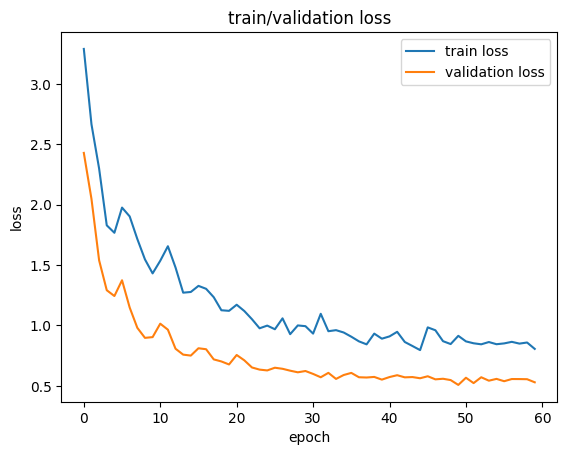

In [95]:
sns.lineplot(train_loss_list, label='train loss')
sns.lineplot(val_loss_list, label='validation loss')
plt.xlabel("epoch")
plt.ylabel('loss')
plt.title('train/validation loss')
plt.show()

<Axes: >

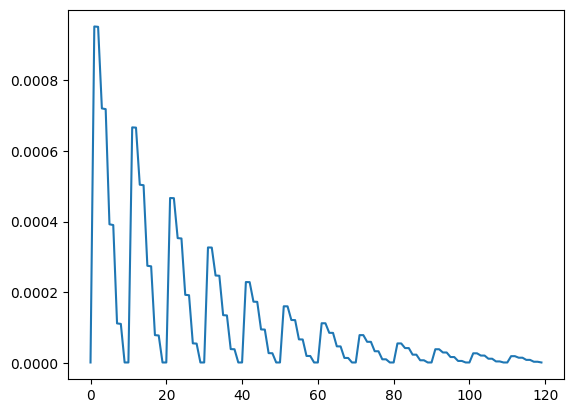

In [96]:
sns.lineplot(lr_list)

In [97]:
test_df = pd.read_csv(os.path.join(data_path, './test.csv'))
test_df.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [98]:
test_img_paths = get_data(test_df, infer=True)

In [99]:
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [100]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()

    model_preds = []

    with torch.no_grad():
        for img in test_loader:
            img = img.float().to(device)

            model_pred = model(img)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()

    print('Done.')
    return model_preds

In [101]:
checkpoint = os.path.join(data_path, f'runs/{run_id}/best_model.pt')
print(f'CHECKPOINT LOADED: {checkpoint}')
infer_model = torch.load(checkpoint)
infer_model.to(device)
infer_model.eval()

CHECKPOINT LOADED: /content/drive/MyDrive/Project/CV/dataset/runs/0/best_model.pt


VitModel(
  (backbone): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU(approximate='none')
      (conv2): ConvNorm(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): ConvNorm(
              (conv): Conv2d(384, 384, kern

In [102]:
preds = inference(infer_model, test_loader, device)

Done.


In [103]:
preds = le.inverse_transform(preds)

In [104]:
submit = pd.read_csv(os.path.join(data_path, './sample_submission.csv'))

In [105]:
submit['artist'] = preds

In [106]:
submit.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Caravaggio
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Edgar Degas


In [107]:
submit.to_csv(os.path.join(data_path, f"./submit_{CFG['FILENAME']}.csv"), index=False)